# Unit 2: Financial Applications of Time Series
Assignment: Financial Applications of Time Series
+ Choose either the Signal Frontier Analysis application or Future Contract Rolling application.
+ Use different stocks than those shown in examples.
+ Create iPython Notebook, including code, output, and graphics.
+ Include an introduction in your notebook to give background on your application.
+ Be sure to explain calculations and output in the appropriate places.
+ List outside references if used.

In [2]:
from __future__ import print_function, division
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
plt.style.use('ggplot')

In [6]:
# #I got my own data
# #method from: http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/
# from pandas_datareader import data
# # Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
# tickers = ['AAPL', 'MSFT', 'SPY', 'IBM', 'GOOG', 'AMZN', 'FB', 'NOK', 'CSCO']
# # Define which online source one should use
# data_source = 'google'
# # We would like all available data from 01/01/2000 until 12/31/2016.
# start_date = '2010-01-01'
# end_date = '2017-12-31'
# # User pandas_reader.data.DataReader to load the desired data. As simple as that.
# panel_data = data.DataReader(tickers, data_source, start_date, end_date)
# #export to excel
# panel_data.to_excel('the_big_4_plus.xlsx')

C:\Users\m\Anaconda3\lib\site-packages\pandas_datareader\google\daily.py:40: UnstableAPIWarning: 
The Google Finance API has not been stable since late 2017. Requests seem
to fail at random. Failure is especially common when bulk downloading.

  warnings.warn(UNSTABLE_WARNING, UnstableAPIWarning)


Before Resample:
df.shape = (861, 8)
After Resample:
df.shape = (891, 7)


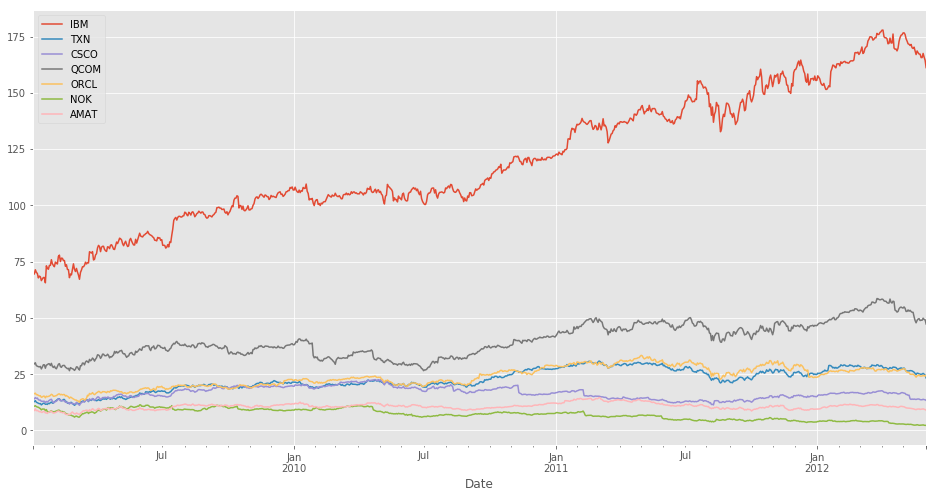

In [5]:
#read in the case study data and the snp data
# df = pd.read_excel('the_big_4_plus.xlsx', sheetname='Close', index_col='Date')
df = pd.read_csv('case_study.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print("Before Resample:\ndf.shape = {}".format(df.shape))
#in case any business days are missing we add them and ffill any missing
df = df.resample('B').pad()
print("After Resample:\ndf.shape = {}".format(df.shape))
#quick plot of df. Its the big 4 plus microsoft and IBM.
#I went with SPY rather than SPX because 'murica
df.plot(figsize=(16, 8))

In [40]:
#it looks like Facebook didn't have presence until around May of 2012
df = df[df['FB'].isnull()==False]
df.index

DatetimeIndex(['2012-05-17', '2012-05-18', '2012-05-21', '2012-05-22',
               '2012-05-23', '2012-05-24', '2012-05-25', '2012-05-28',
               '2012-05-29', '2012-05-30',
               ...
               '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21',
               '2017-12-22', '2017-12-25', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', length=1467, freq='B')

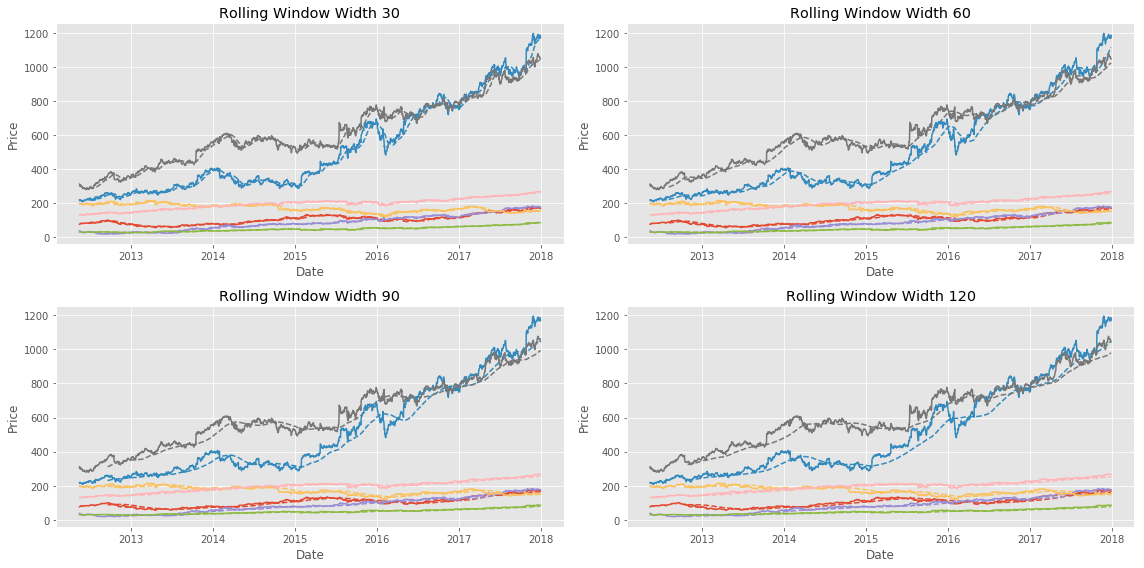

In [41]:
#look at the rolling mean for a few different window widths
plt.figure(figsize=(16,8))
for i, w in enumerate([30, 60, 90, 120]):
    plt.subplot(221+i)
    plt.plot(df.index, df.rolling(w, center=False).mean(), '--')
    plt.plot(df)
    plt.legend()
    plt.title('Rolling Window Width {}'.format(w))
    plt.xlabel('Date')
    plt.ylabel('Price')
plt.tight_layout()

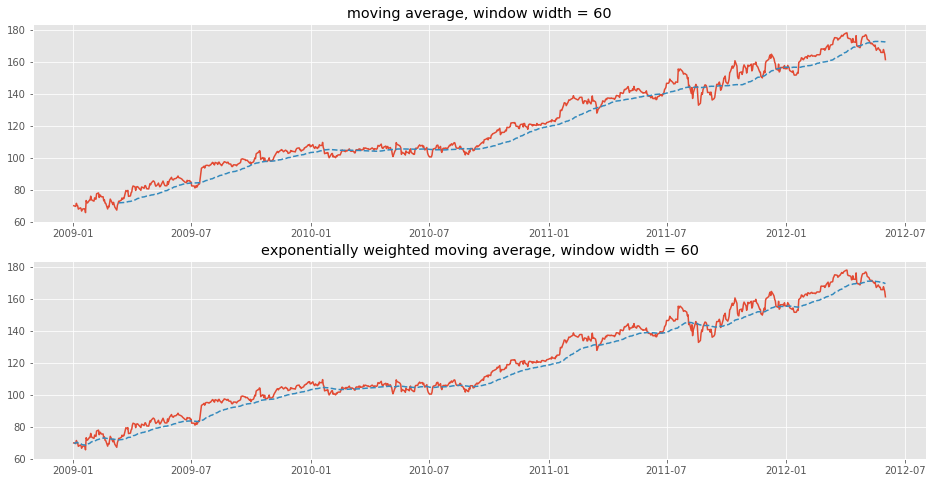

In [4]:
#visualize the different fits between the moving average and the exponentioally weighted moving averages
#with window size 60
avgs = [df.IBM.rolling(60, center=False, min_periods=50).mean(), 'moving average, window width = 60',
        df.IBM.ewm(span=60).mean(), 'exponentially weighted moving average, window width = 60']
plt.figure(figsize=(16,8))
for i, ave in enumerate(zip(avgs[::2], avgs[1::2])):
    plt.subplot(211+i)
    plt.plot(df.index, df.IBM)
    plt.plot(ave[0].index, ave[0], '--')
    plt.title(ave[1])

In [5]:
#what date ranges are in each of df and sp, and how many records
print(df.reset_index()['Date'].describe())
print('='*30)
print(sp.reset_index()['Date'].describe())

count                     891
unique                    891
top       2012-02-14 00:00:00
freq                        1
first     2009-01-02 00:00:00
last      2012-06-01 00:00:00
Name: Date, dtype: object
count                    2108
unique                   2108
top       2016-11-14 00:00:00
freq                        1
first     2010-01-04 00:00:00
last      2018-01-31 00:00:00
Name: Date, dtype: object


In [6]:
#make another data frame called df2 that merges both on their date index
df2 = pd.merge(df, sp, left_index=True, right_index=True)
#print the resultant shape, we only match up on 630 dates between 2010-01-04 to 2012-06-01
print(df2.reset_index()['Date'].describe())

count                     630
unique                    630
top       2012-02-14 00:00:00
freq                        1
first     2010-01-04 00:00:00
last      2012-06-01 00:00:00
Name: Date, dtype: object


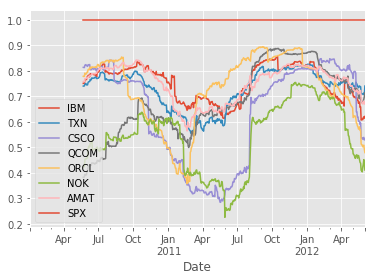

In [7]:
#now we can see how IBM correlates with SPX
spxrets = df2['SPX']/df2['SPX'].shift(1) - 1
rets = df2.pct_change()
corr = rets.rolling(125, min_periods=100).corr(other=spxrets)
corr.plot()

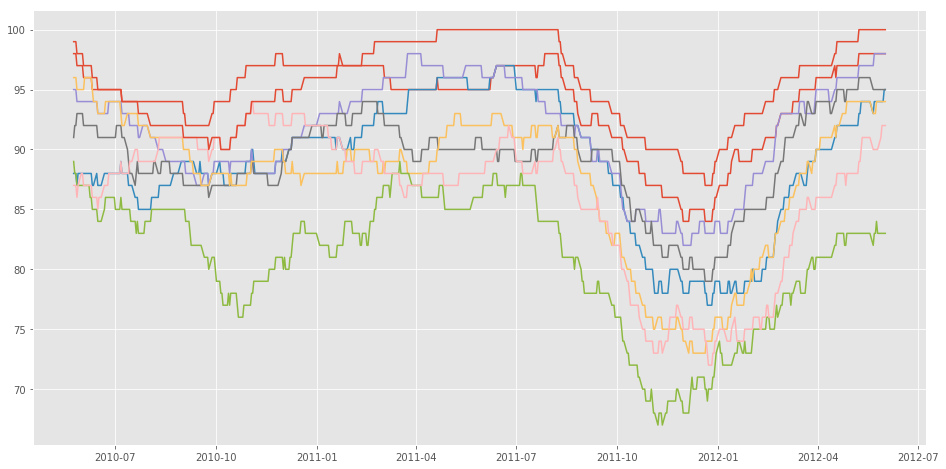

In [8]:
#percentile of score: find out how much of each stock had a return over 2% between each business day
from scipy.stats import percentileofscore
plt.figure(figsize=(16,8))
score_at_2perc = lambda x: percentileofscore(x, 0.02)
res = rets.rolling(100).apply(score_at_2perc)
plt.plot(res.index, res)

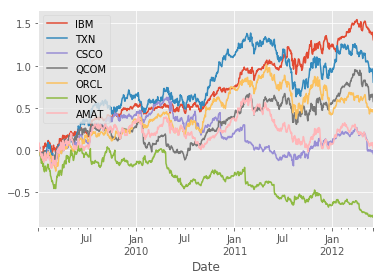

In [9]:
#signal frontier analysis
#plotting the cumulative returns for each stock
((1 + df.pct_change()).cumprod() - 1).plot()

In [10]:
import numpy as np
def calc_mom(price, lookback, lag):
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=True)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0) #old method wasn't working
    return demeaned.divide(demeaned.std(axis=1), axis=0)
compound = lambda x : (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()
def strat_sr(prices, lb, hold):
    # Compute portfolio weights
    freq = '{}B'.format(hold)
    port = calc_mom(prices, lb, lag=1)
    daily_rets = prices.pct_change()
    # Compute portfolio returns
    port = port.shift(1).resample(freq).first() #warning from new version prompted this change
    returns = daily_rets.resample(freq).apply(compound) #warning from new version prompted this change
    port_rets = (port * returns).sum(axis=1)
    return daily_sr(port_rets) * np.sqrt(252 / hold)

In [11]:
from collections import defaultdict
lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(df, lb, hold)
ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

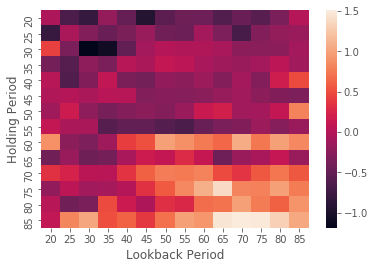

In [12]:
#heatmap to help visualize what the best combinations of holding period and lookback period were
#looks like (lookback, holding) = (55, 75) is best
import seaborn as sns
sns.heatmap(ddf)

In [20]:
from pandas_datareader import data

# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', 'SPY', 'IBM', 'GOOG', 'AMZN', 'FB']

# Define which online source one should use
data_source = 'google'

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2010-01-01'
end_date = '2016-12-31'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, data_source, start_date, end_date)

#export to excel
panel_data.to_excel('the_big_4_plus.xlsx')

C:\Users\m\Anaconda3\lib\site-packages\pandas_datareader\google\daily.py:40: UnstableAPIWarning: 
The Google Finance API has not been stable since late 2017. Requests seem
to fail at random. Failure is especially common when bulk downloading.

  warnings.warn(UNSTABLE_WARNING, UnstableAPIWarning)
